# RF classifier with PCA dimentionality reduction 

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
import joblib
from plot_metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in data and assign X and y
data = pd.read_csv('../../../data/train.csv', index_col=0)
X = data[data.columns.tolist()[:-1]]
y = data[['isGoal']]
X

,time,period,coordinateX,coordinateY,shotDistance,shotAngle,shotType,emptyNet,lastEventType,lastCoordinateX,lastCoordinateY,lastTime,lastShotDistance,rebound,changeShotAngle,speed,friendlyPlayersOnIce,opposingPlayersOnIce,timeSincePP
gameId,,,,,,,,,,,,,,,,,,,
2015020001,51,1,-55.0,6.0,34.5254,10.0080,6,0,5,94.0,-34.0,11,154.2757,0,0.0000,14.0251,5,5,0
2015020001,65,1,-79.0,0.0,10.0000,0.0000,3,0,3,-37.0,-28.0,7,50.4777,0,0.0000,7.2111,5,5,0
2015020001,66,1,-75.0,-1.0,14.0357,-4.0856,3,0,14,-79.0,0.0,1,4.1231,1,-4.0856,4.1231,5,5,0
2015020001,113,1,-55.0,-36.0,49.5177,-46.6366,6,0,5,-91.0,35.0,18,79.6053,0,0.0000,4.4225,5,5,0
2015020001,157,1,-61.0,-1.0,28.0179,-2.0454,4,0,1,-69.0,-22.0,5,22.4722,0,0.0000,4.4944,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018021271,3337,3,67.0,-19.0,29.0689,-40.8151,2,0,3,29.0,35.0,33,66.0303,0,0.0000,2.0009,5,5,0
2018021271,3393,3,-78.0,1.0,11.0454,5.1944,6,0,1,-69.0,-22.0,29,24.6982,0,0.0000,0.8517,5,5,0
2018021271,3519,3,-82.0,10.0,12.2066,55.0080,6,0,6,-71.0,4.0,19,12.5300,0,0.0000,0.6595,5,5,0


In [3]:
X = X.copy()
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])
X

,time,period,coordinateX,coordinateY,shotDistance,shotAngle,shotType,emptyNet,lastEventType,lastCoordinateX,lastCoordinateY,lastTime,lastShotDistance,rebound,changeShotAngle,speed,friendlyPlayersOnIce,opposingPlayersOnIce,timeSincePP
gameId,,,,,,,,,,,,,,,,,,,
2015020001,0.010625,0.0,0.222222,0.571429,0.177708,0.516890,1.000000,0.0,0.3125,0.974747,0.095238,0.056701,0.771378,0.0,0.482454,0.075151,1.0,1.0,0.0
2015020001,0.013542,0.0,0.101010,0.500000,0.047706,0.488447,0.500000,0.0,0.1875,0.313131,0.166667,0.036082,0.252389,0.0,0.482454,0.038639,1.0,1.0,0.0
2015020001,0.013750,0.0,0.121212,0.488095,0.069098,0.476836,0.500000,0.0,0.8750,0.101010,0.500000,0.005155,0.020616,1.0,0.472362,0.022093,1.0,1.0,0.0
2015020001,0.023542,0.0,0.222222,0.071429,0.257177,0.355908,1.000000,0.0,0.3125,0.040404,0.916667,0.092784,0.398027,0.0,0.482454,0.023697,1.0,1.0,0.0
2015020001,0.032708,0.0,0.191919,0.488095,0.143213,0.482634,0.666667,0.0,0.0625,0.151515,0.238095,0.025773,0.112361,0.0,0.482454,0.024082,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018021271,0.695208,0.5,0.838384,0.273810,0.148784,0.372452,0.333333,0.0,0.1875,0.646465,0.916667,0.170103,0.330151,0.0,0.482454,0.010721,1.0,1.0,0.0
2018021271,0.706875,0.5,0.106061,0.511905,0.053247,0.503210,1.000000,0.0,0.0625,0.151515,0.238095,0.149485,0.123491,0.0,0.482454,0.004564,1.0,1.0,0.0
2018021271,0.733125,0.5,0.085859,0.619048,0.059403,0.644778,1.000000,0.0,0.3750,0.141414,0.547619,0.097938,0.062650,0.0,0.482454,0.003534,1.0,1.0,0.0


In [4]:
n_components  = len(X.columns)
#pca = PCA(n_components = len(X.columns))
pca = PCA(n_components = n_components)
pca.fit(X)
X = pca.transform(X)
pca.explained_variance_ratio_


array([0.24708183, 0.1440921 , 0.12191488, 0.1194849 , 0.0738656 ,
       0.06932926, 0.05699787, 0.05622507, 0.04111811, 0.03076605,
       0.01405815, 0.00637229, 0.00436349, 0.00390294, 0.00307161,
       0.00243966, 0.00195895, 0.00165233, 0.00130489])

[0.24708183 0.39117392 0.5130888  0.6325737  0.7064393  0.77576857
 0.83276644 0.88899151 0.93010963 0.96087568 0.97493383 0.98130612
 0.98566961 0.98957256 0.99264416 0.99508382 0.99704277 0.99869511
 1.        ]


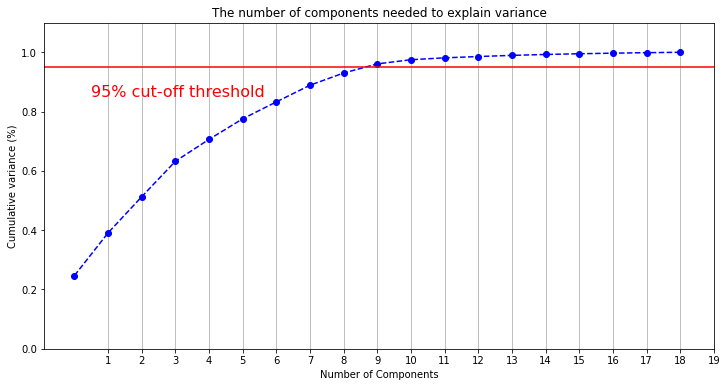

In [5]:

pca = PCA().fit(X)


plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(0, n_components, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
print(y)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, n_components +1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()


In [6]:
X

array([[-2.52181844e-01, -1.65354301e-01, -3.26189239e-01, ...,
         1.61775471e-02, -2.18689397e-02, -1.44825912e-02],
       [-3.25041278e-01,  4.02935043e-01,  1.61774809e-01, ...,
         9.45765423e-03, -1.54454564e-02,  8.10653514e-03],
       [ 8.79928526e-01,  5.56970083e-01,  1.61365353e-01, ...,
         2.95894171e-03, -1.94791824e-02,  1.23562081e-02],
       ...,
       [-1.22604168e-01,  5.43961266e-01, -2.77943741e-01, ...,
         6.20523480e-02, -6.75630334e-03,  1.50900724e-02],
       [ 9.61899908e-01,  5.88068993e-01, -2.83744106e-01, ...,
         1.02268091e-01,  5.62461044e-04,  1.19413819e-02],
       [ 2.65647479e-01, -2.64544359e-02, -2.84433160e-01, ...,
         2.84166898e-02,  1.08905614e-01, -1.69803771e-02]])

In [7]:
pca = PCA(n_components= 10)
X_train_transformed = pca.fit_transform(X)
X_val_transformed = pca.fit_transform(X)
    
print(X_train_transformed.shape)
print(X_train_transformed)

(315532, 10)
[[-0.25218184 -0.1653543  -0.32618924 ...  0.53019297  0.028597
  -0.08766423]
 [-0.32504128  0.40293504  0.16177481 ...  0.04751529 -0.01984578
  -0.11718726]
 [ 0.87992853  0.55697008  0.16136535 ... -0.16058077 -0.11231914
  -0.03640938]
 ...
 [-0.12260417  0.54396127 -0.27794374 ... -0.21691945  0.1587336
  -0.19821705]
 [ 0.96189991  0.58806899 -0.28374411 ... -0.29885317 -0.09309703
  -0.19484823]
 [ 0.26564748 -0.02645444 -0.28443316 ...  0.43389391  0.59133587
  -0.15202452]]
